### **Importing Libraries and defining additional functions**

In [ ]:
!pip install git+https://github.com/fra31/auto-attack --quiet
!pip install easydict

from autoattack import AutoAttack  # Ensure you have installed the AutoAttack library
import matplotlib.pyplot as plt

import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.optim import SGD
import torch.optim as optim
from autoattack import AutoAttack
from torch.utils.data import DataLoader, random_split
import easydict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test_natural(net, test_loader):
    '''Basic testing function.'''

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i,data in enumerate(test_loader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

def pgd_attack(model, x, y, eps, stepsize, iterations, p="inf", targeted=False):
    """
    Implements a flexible PGD attack with support for various norms and targeted/untargeted attacks.

    Args:
    - model: The neural network to attack.
    - x: Input images (original images).
    - y: True labels (untargeted) or target labels (targeted).
    - eps: Radius of the norm-ball for perturbation.
    - stepsize: Step size for gradient update.
    - iterations: Number of PGD steps.
    - p: Norm type ('inf' for l_inf, or any positive integer for l_p norms).
    - targeted: If True, performs a targeted attack; otherwise, untargeted.

    Returns:
    - adv_examples: Adversarial examples (perturbed inputs).
    """
    model.eval()  # Ensure the model is in evaluation mode.
    x.requires_grad = True

    # Initialize perturbations randomly within the norm-ball
    if p == "inf":
        delta = (torch.rand_like(x) * 2 - 1) * eps  # Uniformly distributed in [-eps, eps]
    else:
        delta = torch.randn_like(x)  # Random direction
        norms = torch.norm(delta.view(delta.size(0), -1), dim=1, p=p)
        norms[norms == 0] = 1  # Avoid division by zero
        delta /= norms.view(-1, 1, 1, 1)  # Project onto p-norm ball
        delta *= torch.rand(delta.size(0), 1, 1, 1, device=x.device) * eps

    delta = delta.to(x.device)

    # PGD iterations
    for i in range(iterations):
        adv_examples = x + delta
        adv_examples.requires_grad_(True)

        # Forward pass
        outputs = model(torch.clamp(adv_examples, 0, 1))

        # Compute loss
        loss = F.cross_entropy(outputs, y)
        if targeted:
            loss = -loss  # Minimize loss for targeted attack

        if adv_examples.grad is None:
            adv_examples.retain_grad()  # Allow gradient computation

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Compute gradient step
        if p == "inf":
            gradient = stepsize * adv_examples.grad.sign()
        else:
            gradient = adv_examples.grad
            norms = torch.norm(gradient.view(gradient.size(0), -1), dim=1, p=p)
            norms[norms == 0] = 1  # Avoid division by zero
            gradient /= norms.view(-1, 1, 1, 1)  # Normalize gradient
            gradient *= stepsize

        # Update adversarial examples
        if not targeted:
            delta = delta + gradient
        else:
            delta = delta - gradient

        # Project perturbations back to the norm-ball
        if p == "inf":
            delta = torch.clamp(delta, -eps, eps)
        else:
            norms = torch.norm(delta.view(delta.size(0), -1), dim=1, p=p)
            norms[norms == 0] = 1  # Avoid division by zero
            mask = norms > eps
            delta[mask] /= norms[mask].view(-1, 1, 1, 1)  # Normalize to p-norm ball
            delta[mask] *= eps

    # Create final adversarial examples
    adv_examples = torch.clamp(x + delta, 0, 1)

    return adv_examples


def fgsm_attack(model, images, labels, epsilon,targeted =False):
    """
    Implements FGSM attack with a specified epsilon.

    Args:
    - model: The pretrained PyTorch model.
    - images: Original input images.
    - labels: True labels.
    - epsilon: Perturbation magnitude.

    Returns:
    - adversarial_examples: Perturbed images.
    """
    model.eval()
    # Ensure images have gradients enabled
    images.requires_grad = True

    # Forward pass to compute predictions
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    loss.backward()
    # Generate adversarial perturbations using the sign of the gradient
    perturbations = images.grad.data.sign()

    if not targeted:
      adversarial_examples = images + epsilon * perturbations
    else:
      adversarial_examples = images - epsilon * perturbations

    model.zero_grad()
    # Clip the adversarial examples to stay within valid pixel range [0, 1]
    # adversarial_examples = torch.clamp(adversarial_examples, 0, 1)

    return adversarial_examples

class Net(nn.Module):

    model_file="models/default_model.pth"
    '''This file will be loaded to test your model. Use --model-file to load/store a different model.'''

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

    def save(self, model_file):
        '''Helper function, use it to save the model weights after training.'''
        torch.save(self.state_dict(), model_file)

    def load(self, model_file):
        self.load_state_dict(torch.load(model_file, map_location=torch.device(device), weights_only=True))


    def load_for_testing(self, project_dir='./'):
        '''This function will be called automatically before testing your
           project, and will load the model weights from the file
           specify in Net.model_file.

           You must not change the prototype of this function. You may
           add extra code in its body if you feel it is necessary, but
           beware that paths of files used in this function should be
           refered relative to the root of your project directory.
        '''
        self.load(os.path.join(project_dir, Net.model_file))

# Modified adversarial training function
def adversarial_train_model_single(
    model, train_loader, valid_loader, autoattack, pth_filename,
    num_epochs, epsilon_fgsm, epsilon_pgd, alpha, num_steps
):
    criterion = nn.NLLLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    val_accs = []
    autoattack_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Generate adversarial examples
            fgsm_inputs = fgsm_attack(model, inputs, labels, epsilon_fgsm)
            pgd_inputs = pgd_attack(model, inputs, labels, epsilon_pgd, alpha, num_steps, p="inf", targeted=False)


            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate losses for clean, FGSM, and PGD inputs
            clean_outputs = model(inputs)
            fgsm_outputs = model(fgsm_inputs)
            pgd_outputs = model(pgd_inputs)
            loss = (criterion(clean_outputs, labels) +
                    criterion(fgsm_outputs, labels) +
                    criterion(pgd_outputs, labels)) / 3

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Evaluate after each epoch
        # val_acc = test_natural(model, valid_loader)
    autoattack_acc = test_autoattack(model, autoattack, valid_loader)
        # val_accs.append(val_acc)
    # autoattack_accs.append(autoattack_acc)

    return val_accs, autoattack_acc


# AutoAttack evaluation function
def test_autoattack(model, autoattack, valid_loader):
    model.eval()
    x_list, y_list = [], []
    for data in valid_loader:
        images, labels = data[0].to(device), data[1].to(device)
        x_list.append(images)
        y_list.append(labels)

    x_all = torch.cat(x_list, dim=0)
    y_all = torch.cat(y_list, dim=0)
    adv_acc = autoattack.run_standard_evaluation(x_all, y_all, bs=64)
    with torch.no_grad():
        adv_predictions = model(adv_acc).argmax(dim=1)

    # Compute robust accuracy
    robust_accuracy = (adv_predictions == y_all).float().mean().item()
    print(f"Robust accuracyy: {robust_accuracy * 100:.2f}%")
    return robust_accuracy

  Using cached easydict-1.13-py3-none-any.whl.metadata (4.2 kB)
Using cached easydict-1.13-py3-none-any.whl (6.8 kB)


### **Tuning for FGSM epsilon and alpha values for PGD**

In [ ]:
import matplotlib.pyplot as plt

# Parameter Tuning Ranges
tuning_params = {
    "epsilon_fgsm": [0.01, 0.03, 0.05],
    # "epsilon_pgd": [0.01, 0.03, 0.05],
    "alpha": [0.001, 0.003, 0.005],
    # "num_steps": [7, 10]
}

# Fixed Values for Other Parameters
fixed_config = {
    "epsilon_fgsm": 0.01,
    "epsilon_pgd": 0.01,
    "alpha": 0.001,
    "num_steps": 50
}

# Results storage
tuning_results = {}
args = easydict.EasyDict({
        "train": True,
        "num_epochs": 10,
        "batch_size": 64,
        "lr": 0.001
})

num_epochs = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

valid_length = int(len(train_dataset) * 0.1)
train_length = len(train_dataset) - valid_length

# Split the dataset into training and validation
train_data, valid_data = random_split(train_dataset, [train_length, valid_length])

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=args.batch_size, shuffle=False)

for param, values in tuning_params.items():
    tuning_results[param] = []

    for value in values:
        # Create a modified configuration
        config = fixed_config.copy()
        config[param] = value

        # Train the model with the current configuration
        model = Net().to(device)
        autoattack = AutoAttack(model, norm='Linf', eps=config['epsilon_pgd'], version='standard')

        _, autoattack_accs = adversarial_train_model_single(
            model, train_loader, valid_loader, autoattack, "model.pth",
            num_epochs, config['epsilon_fgsm'], config['epsilon_pgd'], config['alpha'], config['num_steps']
        )

        # Store the final epoch accuracy
        tuning_results[param].append(autoattack_accs)

# Plot the results for each parameter
# for param, results in tuning_results.items():
#     plt.figure(figsize=(10, 5))
#     plt.plot(tuning_params[param], results, marker='o', label=f"Tuning {param}")
#     plt.xlabel(param)
#     plt.ylabel('AutoAttack Accuracy (%)')
#     plt.title(f"Final AutoAttack Accuracy After Tuning {param}")
#     plt.grid(True)
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig(f"{param}_tuning_results.png")
#     plt.show()


100%|██████████| 170498071/170498071 [00:10<00:00, 15783182.60it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
setting parameters for standard version


/tmp/ipykernel_23/836348407.py:86: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /usr/local/src/pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  if adv_examples.grad is None:


using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 46.08%
apgd-ce - 1/36 - 20 out of 64 successfully perturbed
apgd-ce - 2/36 - 24 out of 64 successfully perturbed
apgd-ce - 3/36 - 16 out of 64 successfully perturbed
apgd-ce - 4/36 - 27 out of 64 successfully perturbed
apgd-ce - 5/36 - 17 out of 64 successfully perturbed
apgd-ce - 6/36 - 22 out of 64 successfully perturbed
apgd-ce - 7/36 - 25 out of 64 successfully perturbed
apgd-ce - 8/36 - 21 out of 64 successfully perturbed
apgd-ce - 9/36 - 22 out of 64 successfully perturbed
apgd-ce - 10/36 - 20 out of 64 successfully perturbed
apgd-ce - 11/36 - 24 out of 64 successfully perturbed
apgd-ce - 12/36 - 21 out of 64 successfully perturbed
apgd-ce - 13/36 - 25 out of 64 successfully perturbed
apgd-ce - 14/36 - 21 out of 64 successfully perturbed
apgd-ce - 15/36 - 23 out of 64 successfully perturbed
apgd-ce - 16/36 - 25 out of 64 successfully perturbed
apgd-ce - 17/36 - 29 out of 64 successfully perturbed
a

In [ ]:
import json

print(tuning_results)

# Save tuning results to a JSON file
with open('tuning_results.json', 'w') as f:
    json.dump(tuning_results, f)


{'epsilon_fgsm': [0.2895999848842621, 0.2913999855518341, 0.3009999990463257], 'alpha': [0.29339998960494995, 0.3025999963283539, 0.30239999294281006]}


### **Tuning for PGD L_inf**

In [ ]:
import matplotlib.pyplot as plt

# Parameter Tuning Ranges
tuning_params = {
    #"epsilon_fgsm": [0.01, 0.03, 0.05],
    "epsilon_pgd": [0.01, 0.03, 0.05],
    # "alpha": [0.001, 0.003],
    # "num_steps": [7, 10]
}

# Fixed Values for Other Parameters
fixed_config = {
    "epsilon_fgsm": 0.03,
    "alpha": 0.001,
    "num_steps": 50
}

# Results storage
tuning_results = {}
args = easydict.EasyDict({
        "train": True,
        "num_epochs": 10,
        "batch_size": 64,
        "lr": 0.001
})

num_epochs = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

valid_length = int(len(train_dataset) * 0.1)
train_length = len(train_dataset) - valid_length

# Split the dataset into training and validation
train_data, valid_data = random_split(train_dataset, [train_length, valid_length])

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=args.batch_size, shuffle=False)

for param, values in tuning_params.items():
    tuning_results[param] = []

    for value in values:
        # Create a modified configuration
        config = fixed_config.copy()
        config[param] = value

        # Train the model with the current configuration
        model = Net().to(device)
        autoattack = AutoAttack(model, norm='Linf', eps=config['epsilon_pgd'], version='standard')

        _, autoattack_accs = adversarial_train_model_single(
            model, train_loader, valid_loader, autoattack, "model.pth",
            num_epochs, config['epsilon_fgsm'], config['epsilon_pgd'], config['alpha'], config['num_steps']
        )

        # Store the final epoch accuracy
        tuning_results[param].append(autoattack_accs)


Files already downloaded and verified
Files already downloaded and verified
setting parameters for standard version


<ipython-input-12-deb2337de540>:66: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if adv_examples.grad is None:


using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 42.70%
apgd-ce - 1/34 - 18 out of 64 successfully perturbed
apgd-ce - 2/34 - 22 out of 64 successfully perturbed
apgd-ce - 3/34 - 12 out of 64 successfully perturbed
apgd-ce - 4/34 - 12 out of 64 successfully perturbed
apgd-ce - 5/34 - 21 out of 64 successfully perturbed
apgd-ce - 6/34 - 16 out of 64 successfully perturbed
apgd-ce - 7/34 - 20 out of 64 successfully perturbed
apgd-ce - 8/34 - 16 out of 64 successfully perturbed
apgd-ce - 9/34 - 16 out of 64 successfully perturbed
apgd-ce - 10/34 - 14 out of 64 successfully perturbed
apgd-ce - 11/34 - 25 out of 64 successfully perturbed
apgd-ce - 12/34 - 25 out of 64 successfully perturbed
apgd-ce - 13/34 - 17 out of 64 successfully perturbed
apgd-ce - 14/34 - 18 out of 64 successfully perturbed
apgd-ce - 15/34 - 17 out of 64 successfully perturbed
apgd-ce - 16/34 - 9 out of 64 successfully perturbed
apgd-ce - 17/34 - 29 out of 64 successfully perturbed
ap

### **Tuning for PGD L2**

In [ ]:

# Modified adversarial training function
def adversarial_train_model_single(
    model, train_loader, valid_loader, autoattack, pth_filename,
    num_epochs, epsilon_fgsm, epsilon_pgd, alpha, num_steps
):
    criterion = nn.NLLLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    val_accs = []
    autoattack_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Generate adversarial examples
            fgsm_inputs = fgsm_attack(model, inputs, labels, epsilon_fgsm)
            pgd_inputs = pgd_attack(model, inputs, labels, epsilon_pgd, alpha, num_steps,p=2)


            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate losses for clean, FGSM, and PGD inputs
            clean_outputs = model(inputs)
            fgsm_outputs = model(fgsm_inputs)
            pgd_outputs = model(pgd_inputs)
            loss = (criterion(clean_outputs, labels) +
                    criterion(fgsm_outputs, labels) +
                    criterion(pgd_outputs, labels)) / 3

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Evaluate after each epoch
        # val_acc = test_natural(model, valid_loader)
    autoattack_acc = test_autoattack(model, autoattack, valid_loader)
        # val_accs.append(val_acc)
    # autoattack_accs.append(autoattack_acc)

    return val_accs, autoattack_acc


In [ ]:
import matplotlib.pyplot as plt

# Parameter Tuning Ranges
tuning_params = {
    #"epsilon_fgsm": [0.01, 0.03, 0.05],
    "epsilon_pgd": [0.01, 0.03, 0.05],
    # "alpha": [0.001, 0.003],
    # "num_steps": [7, 10]
}

# Fixed Values for Other Parameters
fixed_config = {
    "epsilon_fgsm": 0.03,
    "alpha": 0.001,
    "num_steps": 50
}

# Results storage
tuning_results = {}
args = easydict.EasyDict({
        "train": True,
        "num_epochs": 10,
        "batch_size": 64,
        "lr": 0.001
})

num_epochs = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

valid_length = int(len(train_dataset) * 0.1)
train_length = len(train_dataset) - valid_length

# Split the dataset into training and validation
train_data, valid_data = random_split(train_dataset, [train_length, valid_length])

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=args.batch_size, shuffle=False)

for param, values in tuning_params.items():
    tuning_results[param] = []

    for value in values:
        # Create a modified configuration
        config = fixed_config.copy()
        config[param] = value

        # Train the model with the current configuration
        model = Net().to(device)
        autoattack = AutoAttack(model, norm='Linf', eps=config['epsilon_pgd'], version='standard')

        _, autoattack_accs = adversarial_train_model_single(
            model, train_loader, valid_loader, autoattack, "model.pth",
            num_epochs, config['epsilon_fgsm'], config['epsilon_pgd'], config['alpha'], config['num_steps']
        )

        # Store the final epoch accuracy
        tuning_results[param].append(autoattack_accs)


Files already downloaded and verified
Files already downloaded and verified
setting parameters for standard version


/tmp/ipykernel_23/2590399347.py:66: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /usr/local/src/pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  if adv_examples.grad is None:


using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 43.34%
apgd-ce - 1/34 - 17 out of 64 successfully perturbed
apgd-ce - 2/34 - 22 out of 64 successfully perturbed
apgd-ce - 3/34 - 17 out of 64 successfully perturbed
apgd-ce - 4/34 - 18 out of 64 successfully perturbed
apgd-ce - 5/34 - 16 out of 64 successfully perturbed
apgd-ce - 6/34 - 17 out of 64 successfully perturbed
apgd-ce - 7/34 - 18 out of 64 successfully perturbed
apgd-ce - 8/34 - 17 out of 64 successfully perturbed
apgd-ce - 9/34 - 22 out of 64 successfully perturbed
apgd-ce - 10/34 - 15 out of 64 successfully perturbed
apgd-ce - 11/34 - 20 out of 64 successfully perturbed
apgd-ce - 12/34 - 16 out of 64 successfully perturbed
apgd-ce - 13/34 - 18 out of 64 successfully perturbed
apgd-ce - 14/34 - 15 out of 64 successfully perturbed
apgd-ce - 15/34 - 17 out of 64 successfully perturbed
apgd-ce - 16/34 - 19 out of 64 successfully perturbed
apgd-ce - 17/34 - 17 out of 64 successfully perturbed
a

### **Plots**

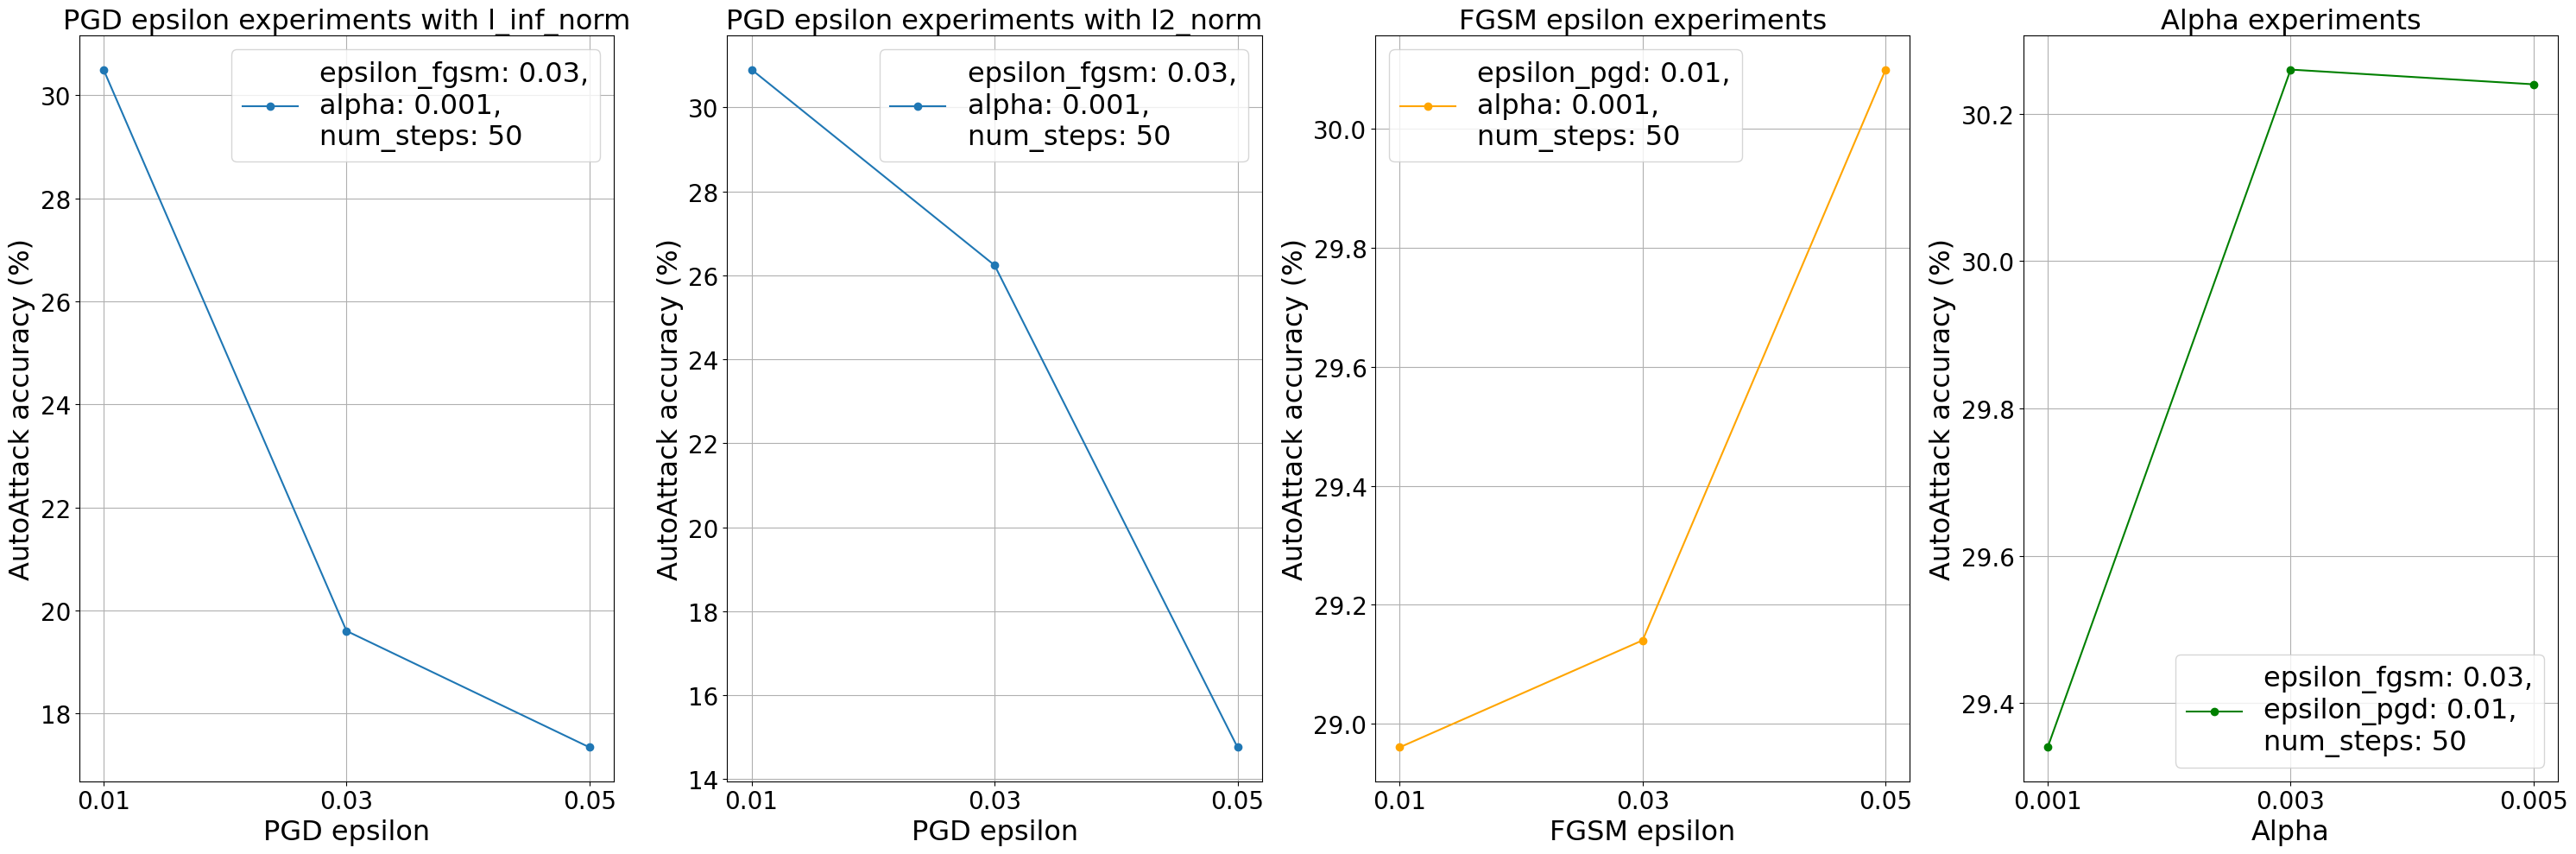

In [ ]:
import matplotlib.pyplot as plt

# Data for PGD epsilon experiments
pgd_epsilon = [0.01, 0.03, 0.05]
pgd_acc = [30.50000071525574, 19.599999487400055, 17.339999973773956]

pgd_epsilon_l2 = [0.01, 0.03, 0.05]
pgd_acc_l2 = [30.89999854564667, 26.24000012874603, 14.7599995136261]

# Data for FGSM epsilon experiments
fgsm_epsilon = [0.01, 0.03, 0.05]
fgsm_acc = [28.95999848842621, 29.13999855518341, 30.09999990463257]

# Data for alpha experiments
alpha = [0.001, 0.003, 0.005]
alpha_acc = [29.339998960494995, 30.25999963283539, 30.239999294281006]

# Create a figure
plt.figure(figsize=(30, 10))

# Plot for PGD epsilon experiments
plt.subplot(1, 4, 1)
plt.plot(pgd_epsilon, pgd_acc, marker='o', label='epsilon_fgsm: 0.03,\nalpha: 0.001,\nnum_steps: 50')
plt.xlabel('PGD epsilon', fontsize=23)
plt.ylabel('AutoAttack accuracy (%)', fontsize=23)
plt.title('PGD epsilon experiments with l_inf_norm', fontsize=23)
plt.xticks(pgd_epsilon, fontsize=20)  # Custom x-ticks
plt.yticks(fontsize=20)
plt.grid(True)
plt.legend(loc='upper right', fontsize=23)
# plt.text(0.01, 50, '"epsilon_fgsm": 0.03,\n"alpha": 0.001,\n"num_steps": 50', fontsize=16, va='top', ha='left')

plt.subplot(1, 4, 2)
plt.plot(pgd_epsilon_l2, pgd_acc_l2, marker='o', label='epsilon_fgsm: 0.03,\nalpha: 0.001,\nnum_steps: 50')
plt.xlabel('PGD epsilon', fontsize=23)
plt.ylabel('AutoAttack accuracy (%)', fontsize=23)
plt.title('PGD epsilon experiments with l2_norm', fontsize=23)
plt.xticks(pgd_epsilon, fontsize=20)  # Custom x-ticks
plt.yticks(fontsize=20)
plt.grid(True)
plt.legend(loc='upper right', fontsize=23)


# Plot for FGSM epsilon experiments
plt.subplot(1, 4, 3)
plt.plot(fgsm_epsilon, fgsm_acc, marker='o', label='epsilon_pgd: 0.01,\nalpha: 0.001,\nnum_steps: 50', color='orange')
plt.xlabel('FGSM epsilon', fontsize=23)
plt.ylabel('AutoAttack accuracy (%)', fontsize=23)
plt.title('FGSM epsilon experiments', fontsize=23)
plt.xticks(fgsm_epsilon, fontsize=20)  # Custom x-ticks
plt.yticks(fontsize=20)
plt.grid(True)
plt.legend(loc='upper left', fontsize=23)

# Plot for Alpha experiments
plt.subplot(1, 4, 4)
plt.plot(alpha, alpha_acc, marker='o', label='epsilon_fgsm: 0.03,\nepsilon_pgd: 0.01,\nnum_steps: 50', color='green')
plt.xlabel('Alpha', fontsize=23)
plt.ylabel('AutoAttack accuracy (%)', fontsize=23)
plt.title('Alpha experiments', fontsize=23)
plt.xticks(alpha, fontsize=20)  # Custom x-ticks
plt.yticks(fontsize=20)
plt.grid(True)
plt.legend(loc='lower right', fontsize=23)

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig("epsilon_experiments.pdf", format='pdf')
plt.show()


### **Final Training**

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test_natural(net, test_loader):
    '''Basic testing function.'''

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i,data in enumerate(test_loader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

def pgd_attack(model, x, y, eps, stepsize, iterations, p="inf", targeted=False):
    """
    Implements a flexible PGD attack with support for various norms and targeted/untargeted attacks.

    Args:
    - model: The neural network to attack.
    - x: Input images (original images).
    - y: True labels (untargeted) or target labels (targeted).
    - eps: Radius of the norm-ball for perturbation.
    - stepsize: Step size for gradient update.
    - iterations: Number of PGD steps.
    - p: Norm type ('inf' for l_inf, or any positive integer for l_p norms).
    - targeted: If True, performs a targeted attack; otherwise, untargeted.

    Returns:
    - adv_examples: Adversarial examples (perturbed inputs).
    """
    model.eval()  # Ensure the model is in evaluation mode.
    x.requires_grad = True

    # Initialize perturbations randomly within the norm-ball
    if p == "inf":
        delta = (torch.rand_like(x) * 2 - 1) * eps  # Uniformly distributed in [-eps, eps]
    else:
        delta = torch.randn_like(x)  # Random direction
        norms = torch.norm(delta.view(delta.size(0), -1), dim=1, p=p)
        norms[norms == 0] = 1  # Avoid division by zero
        delta /= norms.view(-1, 1, 1, 1)  # Project onto p-norm ball
        delta *= torch.rand(delta.size(0), 1, 1, 1, device=x.device) * eps

    delta = delta.to(x.device)

    # PGD iterations
    for i in range(iterations):
        adv_examples = x + delta
        adv_examples.requires_grad_(True)

        # Forward pass
        outputs = model(torch.clamp(adv_examples, 0, 1))

        # Compute loss
        loss = F.cross_entropy(outputs, y)
        if targeted:
            loss = -loss  # Minimize loss for targeted attack

        if adv_examples.grad is None:
            adv_examples.retain_grad()  # Allow gradient computation

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Compute gradient step
        if p == "inf":
            gradient = stepsize * adv_examples.grad.sign()
        else:
            gradient = adv_examples.grad
            norms = torch.norm(gradient.view(gradient.size(0), -1), dim=1, p=p)
            norms[norms == 0] = 1  # Avoid division by zero
            gradient /= norms.view(-1, 1, 1, 1)  # Normalize gradient
            gradient *= stepsize

        # Update adversarial examples
        if not targeted:
            delta = delta + gradient
        else:
            delta = delta - gradient

        # Project perturbations back to the norm-ball
        if p == "inf":
            delta = torch.clamp(delta, -eps, eps)
        else:
            norms = torch.norm(delta.view(delta.size(0), -1), dim=1, p=p)
            norms[norms == 0] = 1  # Avoid division by zero
            mask = norms > eps
            delta[mask] /= norms[mask].view(-1, 1, 1, 1)  # Normalize to p-norm ball
            delta[mask] *= eps

    # Create final adversarial examples
    adv_examples = torch.clamp(x + delta, 0, 1)

    return adv_examples


def fgsm_attack(model, images, labels, epsilon,targeted =False):
    """
    Implements FGSM attack with a specified epsilon.

    Args:
    - model: The pretrained PyTorch model.
    - images: Original input images.
    - labels: True labels.
    - epsilon: Perturbation magnitude.

    Returns:
    - adversarial_examples: Perturbed images.
    """
    model.eval()
    # Ensure images have gradients enabled
    images.requires_grad = True

    # Forward pass to compute predictions
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    loss.backward()
    # Generate adversarial perturbations using the sign of the gradient
    perturbations = images.grad.data.sign()

    if not targeted:
      adversarial_examples = images + epsilon * perturbations
    else:
      adversarial_examples = images - epsilon * perturbations

    model.zero_grad()
    # Clip the adversarial examples to stay within valid pixel range [0, 1]
    # adversarial_examples = torch.clamp(adversarial_examples, 0, 1)

    return adversarial_examples

class Net(nn.Module):

    model_file="models/default_model.pth"
    '''This file will be loaded to test your model. Use --model-file to load/store a different model.'''

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

    def save(self, model_file):
        '''Helper function, use it to save the model weights after training.'''
        torch.save(self.state_dict(), model_file)

    def load(self, model_file):
        self.load_state_dict(torch.load(model_file, map_location=torch.device(device), weights_only=True))


    def load_for_testing(self, project_dir='./'):
        '''This function will be called automatically before testing your
           project, and will load the model weights from the file
           specify in Net.model_file.

           You must not change the prototype of this function. You may
           add extra code in its body if you feel it is necessary, but
           beware that paths of files used in this function should be
           refered relative to the root of your project directory.
        '''
        self.load(os.path.join(project_dir, Net.model_file))

# Modified adversarial training function
def adversarial_train_model_single(
    model, train_loader, valid_loader, autoattack, pth_filename,
    num_epochs, epsilon_fgsm, epsilon_pgd, alpha, num_steps
):
    criterion = nn.NLLLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    val_accs = []
    autoattack_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Generate adversarial examples
            fgsm_inputs = fgsm_attack(model, inputs, labels, epsilon_fgsm)
            pgd_inputs = pgd_attack(model, inputs, labels, epsilon_pgd, alpha, num_steps)


            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate losses for clean, FGSM, and PGD inputs
            clean_outputs = model(inputs)
            fgsm_outputs = model(fgsm_inputs)
            pgd_outputs = model(pgd_inputs)
            loss = (criterion(clean_outputs, labels) +
                    criterion(fgsm_outputs, labels) +
                    criterion(pgd_outputs, labels)) / 3

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Evaluate after each epoch
        # val_acc = test_natural(model, valid_loader)
    autoattack_acc = test_autoattack(model, autoattack, valid_loader)
        # val_accs.append(val_acc)
    # autoattack_accs.append(autoattack_acc)

    return val_accs, autoattack_acc


# AutoAttack evaluation function
def test_autoattack(model, autoattack, valid_loader):
    model.eval()
    x_list, y_list = [], []
    for data in valid_loader:
        images, labels = data[0].to(device), data[1].to(device)
        x_list.append(images)
        y_list.append(labels)

    x_all = torch.cat(x_list, dim=0)
    y_all = torch.cat(y_list, dim=0)
    adv_acc = autoattack.run_standard_evaluation(x_all, y_all, bs=64)
    with torch.no_grad():
        adv_predictions = model(adv_acc).argmax(dim=1)

    # Compute robust accuracy
    robust_accuracy = (adv_predictions == y_all).float().mean().item()
    print(f"Robust accuracyy: {robust_accuracy * 100:.2f}%")
    return robust_accuracy

In [ ]:
import matplotlib.pyplot as plt

#Parameter Tuning Ranges
tuning_params = {
    "epsilon_fgsm": [0.05],
    # "epsilon_pgd": [0.01, 0.03, 0.05],
    "alpha": [0.003],
    # "num_steps": [7, 10]
}

# Fixed Values for Other Parameters
fixed_config = {
    "epsilon_fgsm": 0.05,
    "epsilon_pgd": 0.01,
    "alpha": 0.003,
    "num_steps": 50
}


# Results storage
tuning_results = {}
args = easydict.EasyDict({
        "train": True,
        "num_epochs": 10,
        "batch_size": 64,
        "lr": 0.001
})

num_epochs = 30

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

valid_length = int(len(train_dataset) * 0.1)
train_length = len(train_dataset) - valid_length

# Split the dataset into training and validation
train_data, valid_data = random_split(train_dataset, [train_length, valid_length])

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=args.batch_size, shuffle=False)

for param, values in tuning_params.items():
    tuning_results[param] = []

    for value in values:
        # Create a modified configuration
        config = fixed_config.copy()
        config[param] = value

        # Train the model with the current configuration
        model = Net().to(device)
        autoattack = AutoAttack(model, norm='L2', eps=config['epsilon_pgd'], version='standard')

        _, autoattack_accs = adversarial_train_model_single(
            model, train_loader, valid_loader, autoattack, "model.pth",
            num_epochs, config['epsilon_fgsm'], config['epsilon_pgd'], config['alpha'], config['num_steps']
        )

        # Store the final epoch accuracy
        tuning_results[param].append(autoattack_accs)

# Plot the results for each parameter
# for param, results in tuning_results.items():
#     plt.figure(figsize=(10, 5))
#     plt.plot(tuning_params[param], results, marker='o', label=f"Tuning {param}")
#     plt.xlabel(param)
#     plt.ylabel('AutoAttack Accuracy (%)')
#     plt.title(f"Final AutoAttack Accuracy After Tuning {param}")
#     plt.grid(True)
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig(f"{param}_tuning_results.png")
#     plt.show()


Files already downloaded and verified
Files already downloaded and verified
setting parameters for standard version


/tmp/ipykernel_23/3967458119.py:66: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /usr/local/src/pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  if adv_examples.grad is None:


using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 51.58%
apgd-ce - 1/41 - 13 out of 64 successfully perturbed
apgd-ce - 2/41 - 15 out of 64 successfully perturbed
apgd-ce - 3/41 - 10 out of 64 successfully perturbed
apgd-ce - 4/41 - 15 out of 64 successfully perturbed
apgd-ce - 5/41 - 14 out of 64 successfully perturbed
apgd-ce - 6/41 - 21 out of 64 successfully perturbed
apgd-ce - 7/41 - 14 out of 64 successfully perturbed
apgd-ce - 8/41 - 15 out of 64 successfully perturbed
apgd-ce - 9/41 - 14 out of 64 successfully perturbed
apgd-ce - 10/41 - 12 out of 64 successfully perturbed
apgd-ce - 11/41 - 20 out of 64 successfully perturbed
apgd-ce - 12/41 - 13 out of 64 successfully perturbed
apgd-ce - 13/41 - 11 out of 64 successfully perturbed
apgd-ce - 14/41 - 14 out of 64 successfully perturbed
apgd-ce - 15/41 - 10 out of 64 successfully perturbed
apgd-ce - 16/41 - 10 out of 64 successfully perturbed
apgd-ce - 17/41 - 12 out of 64 successfully perturbed
a